In [3]:
# coding: utf-8
import time
import struct
import pprint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.utils.np_utils import to_categorical
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets("../MNIST_data/")

# Digit 0-4
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]
y_test1 = to_categorical(y_test1, num_classes=5)

# Digit 5-9
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

y_valid2_full = to_categorical(y_valid2_full, num_classes=5)
y_test2 = to_categorical(y_test2, num_classes=5)

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
image_per_digit = [100, 100, 100, 100, 100] # 5-9
X_train2_100 = []
y_train2_100 = []
for image, label in zip(X_train2_full, y_train2_full):
    if image_per_digit[label] > 0:
        X_train2_100.append(image)
        y_train2_100.append(label)
        image_per_digit[label] -= 1
        if all(v == 0 for v in image_per_digit):
            y_train2_100 = to_categorical(y_train2_100, num_classes=5)
            break

y_train2_full = to_categorical(y_train2_full, num_classes=5)

In [6]:
def show_img_label():
    for i in range(5):
        first_image = X_train2_100[i]
        first_label = y_train2_100[i]
        first_image = np.array(first_image, dtype='float')
        pixels = first_image.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.title(first_label)
        plt.show()

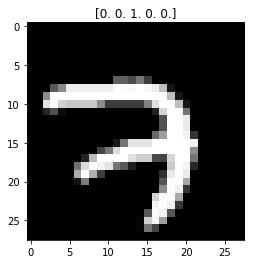

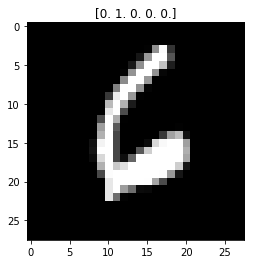

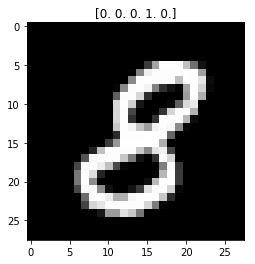

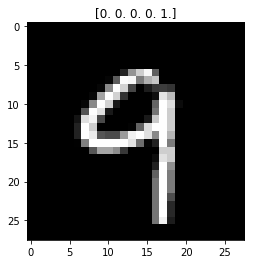

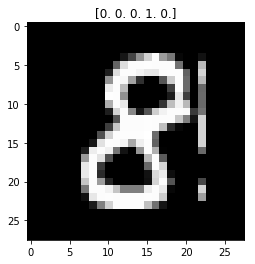

In [7]:
show_img_label()

In [8]:
def DNN(epoch, learning_rate, batch_size, early_stopping):        
    tf.reset_default_graph()

    restore_saver = tf.train.import_meta_graph("./previous_model/final_model.meta")
    
    training_id = '[learning_rate_%.4f, batch_size_%d, early_stopping_%d]' % (learning_rate, batch_size, early_stopping)
    print(training_id)
    training_id += "-" + datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "tf_logs/{}/".format(training_id)
    
    # Load variables and operations for the previous model
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="W_output_layer|output_layer")
    
#     print(len(train_vars))
#     for i in train_vars:
#         print(i)
    
    # Get restored variables and operations
    X = tf.get_default_graph().get_tensor_by_name("input/input_x:0")
    y = tf.get_default_graph().get_tensor_by_name("input/label_y:0")
    loss = tf.get_default_graph().get_tensor_by_name("cross_entropy/cross_entropy:0")
    acc = tf.get_default_graph().get_tensor_by_name("accuracy/accuracy:0")
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss, var_list=train_vars)
    
    batch = int(len(X_train2_100) / batch_size)
    
    best_vali_acc = 0.0
    best_vali_loss = 999.9
    
#     saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_saver.restore(sess, "./previous_model/final_model")
        
        t0 = time.time()
        
#         merged = tf.summary.merge_all()    
#         writer = tf.summary.FileWriter(logdir, sess.graph)
        
        for i in range(epoch):
            for j in range(batch):
                batch_x = X_train2_100[j * batch_size : (j + 1) * batch_size]
                batch_y = y_train2_100[j * batch_size : (j + 1) * batch_size]
                sess.run(training_op, feed_dict={X: batch_x, y: batch_y})
                
#             result = sess.run(merged, feed_dict={X: X_valid2_full, y: y_valid2_full})
#             writer.add_summary(result, i + 1)
            
            vali_acc = sess.run(acc, feed_dict={X: X_valid2_full, y: y_valid2_full})
            vali_loss = sess.run(loss, feed_dict={X: X_valid2_full, y: y_valid2_full})
                
            # Early stopping
            if vali_acc < best_vali_acc:
                n += 1
            else:
                n = 0
                best_vali_loss = vali_loss
                best_vali_acc = vali_acc
            
            print("Epoch: %3d, Validation loss: %.4f, Best loss: %.4f, Accuracy: %.4f, Best Accuracy:%.4f" % (i+1 ,vali_loss, best_vali_loss, vali_acc, best_vali_acc)) 
                
            if n > early_stopping:
                print('Early Stopping at epoch %d' % (i + 1))
                break
                
        t1 = time.time()
        
        print("Total training time: {:.1f}s".format(t1 - t0))
        
        file_name = 'final_model'
        save_path = restore_saver.save(sess, "regular_train/%s/%s" %(training_id, file_name))
#         print("Model saved in path: %s" % save_path)
        
        test_acc = sess.run(acc, feed_dict={X: X_test2, y: y_test2})
        print("Final test accuracy: %.4f" % test_acc)     

In [9]:
DNN(epoch=1000, learning_rate=0.9, batch_size=50, early_stopping=30)

[learning_rate_0.9000, batch_size_50, early_stopping_30]
INFO:tensorflow:Restoring parameters from ./previous_model/final_model
Epoch:   1, Validation loss: 1.2125, Best loss: 1.2125, Accuracy: 0.6933, Best Accuracy:0.6933
Epoch:   2, Validation loss: 1.1967, Best loss: 1.1967, Accuracy: 0.7064, Best Accuracy:0.7064
Epoch:   3, Validation loss: 1.1779, Best loss: 1.1779, Accuracy: 0.7269, Best Accuracy:0.7269
Epoch:   4, Validation loss: 1.1772, Best loss: 1.1779, Accuracy: 0.7219, Best Accuracy:0.7269
Epoch:   5, Validation loss: 1.1740, Best loss: 1.1740, Accuracy: 0.7277, Best Accuracy:0.7277
Epoch:   6, Validation loss: 1.1634, Best loss: 1.1634, Accuracy: 0.7408, Best Accuracy:0.7408
Epoch:   7, Validation loss: 1.1595, Best loss: 1.1595, Accuracy: 0.7408, Best Accuracy:0.7408
Epoch:   8, Validation loss: 1.1585, Best loss: 1.1585, Accuracy: 0.7445, Best Accuracy:0.7445
Epoch:   9, Validation loss: 1.1552, Best loss: 1.1552, Accuracy: 0.7461, Best Accuracy:0.7461
Epoch:  10, Valid

In [10]:
%save MNIST_transfer_learning.py 3-9

The following commands were written to file `MNIST_transfer_learning.py`:

import time
import struct
import pprint
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from keras.utils.np_utils import to_categorical
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/")

# Digit 0-4
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]
y_test1 = to_categorical(y_test1, num_classes=5)

# Digit 5-9
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

y_valid2_full = to_categorical(y_valid2_full, num_classes=5)
y_test